# Lego Marketing Sentiment

## <em>Using Sentiment Analysis to analyse consumer sentiment towards Lego marketing campaigns.</em>

The libraries used for this project include:
- Python v3.9.1
- PySpark v3.4.0
- Emoji
- Instaloader (as example of getting individual Instagram posts)
- Seaborn

## Project Features

- Ingestion of data using structured streaming dataframes
- Logistic Regression classifier model for sentiment analysis
- Sample Dashboard widget demo

## Why Logistic Regression?

- binary data classification (positive or negative)
- Handles noisier data better
- Fast, needs less computational resource


> **PLEASE NOTE**
> An official social media api was not used for the following reasons:
>
> - Twitter has changed the data available for free tier, so streaming tweets wasn't possible.
> - Instagram and Facebook have a manual authorisation process which would not be completed before project due date.
>
> Thus, an Instagram comment dataset csv was created, and will be used to simulate streaming data.

The training set for this project can be found here: [Sentiment401](http://help.sentiment140.com/for-students/])

In [1]:
#Import libraries
from pyspark import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.streaming import StreamingContext
import pyspark.sql.types as tp
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.feature import StopWordsRemover, Word2Vec, RegexTokenizer
from pyspark.ml.classification import LogisticRegression
from pyspark.sql import Row
from pyspark.sql.functions import col, udf, lit
from pyspark.sql.functions import lower, countDistinct
from pyspark.sql.functions import regexp_replace
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, CountVectorizer
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import shutil
import re
import operator
import functools
import requests
import json
import time
import instaloader
from bs4 import BeautifulSoup
import emoji
import os
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nest_asyncio

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

#Below prevents errors when running spark sessions in jupyter
nest_asyncio.apply()


In [2]:
# initializing spark session
sc = SparkContext(appName="LegoSentiment")
spark = SparkSession(sc)

## Model Pipeline Definition, Training and Evaluation

See Above for training dataset used.

In [3]:
# define schemas for training and instagram post data
train_schema = tp.StructType([
    tp.StructField(name= 'polarity', dataType= tp.IntegerType(),  nullable= True),
    tp.StructField(name= 'comment_id', dataType= tp.IntegerType(),   nullable= True),
    tp.StructField(name= 'date', dataType= tp.TimestampType(),  nullable= True),
    tp.StructField(name= 'query', dataType= tp.StringType(),   nullable= True),
    tp.StructField(name= 'username', dataType= tp.StringType(),   nullable= True),
    tp.StructField(name= 'comment', dataType= tp.StringType(),   nullable= True)                
  ,
])

insta_schema = tp.StructType([
    tp.StructField(name= 'id', dataType= tp.IntegerType(),  nullable= True),
    tp.StructField(name= 'username', dataType= tp.StringType(),   nullable= True),
    tp.StructField(name= 'comment', dataType= tp.StringType(),   nullable= True),
    tp.StructField(name= 'comment_id', dataType= tp.IntegerType(),   nullable= True),
    tp.StructField(name= 'profile_url', dataType= tp.StringType(),   nullable= True),
    tp.StructField(name= 'comment_url', dataType= tp.StringType(),   nullable= True)                
  ,
])

In [4]:
#Load training data
training_data = spark.read.csv('C:/Users/hayle/Desktop/lego_post_data/sentiment_model_data/training_data.csv',schema = train_schema,header=True)

In [5]:
# view the data and deal with null values
df = training_data.na.fill('')
df = df.na.fill(value=0)
df.show(20)

+--------+----------+----+--------+---------------+--------------------+
|polarity|comment_id|date|   query|       username|             comment|
+--------+----------+----+--------+---------------+--------------------+
|       0|1467810672|null|NO_QUERY|  scotthamilton|is upset that he ...|
|       0|1467810917|null|NO_QUERY|       mattycus|@Kenichan I dived...|
|       0|1467811184|null|NO_QUERY|        ElleCTF|my whole body fee...|
|       0|1467811193|null|NO_QUERY|         Karoli|@nationwideclass ...|
|       0|1467811372|null|NO_QUERY|       joy_wolf|@Kwesidei not the...|
|       0|1467811592|null|NO_QUERY|        mybirch|         Need a hug |
|       0|1467811594|null|NO_QUERY|           coZZ|@LOLTrish hey  lo...|
|       0|1467811795|null|NO_QUERY|2Hood4Hollywood|@Tatiana_K nope t...|
|       0|1467812025|null|NO_QUERY|        mimismo|@twittera que me ...|
|       0|1467812416|null|NO_QUERY| erinx3leannexo|spring break in p...|
|       0|1467812579|null|NO_QUERY|   pardonlauren|

In [6]:
#Drop unneccessary colums and drop usernames to anonymise data
df = df.drop('query')
df = df.drop('username')
df = df.drop('date')
df.show(20)

#How many entries in training data
df.count()

+--------+----------+--------------------+
|polarity|comment_id|             comment|
+--------+----------+--------------------+
|       0|1467810672|is upset that he ...|
|       0|1467810917|@Kenichan I dived...|
|       0|1467811184|my whole body fee...|
|       0|1467811193|@nationwideclass ...|
|       0|1467811372|@Kwesidei not the...|
|       0|1467811592|         Need a hug |
|       0|1467811594|@LOLTrish hey  lo...|
|       0|1467811795|@Tatiana_K nope t...|
|       0|1467812025|@twittera que me ...|
|       0|1467812416|spring break in p...|
|       0|1467812579|I just re-pierced...|
|       0|1467812723|@caregiving I cou...|
|       0|1467812771|@octolinz16 It it...|
|       0|1467812784|@smarrison i woul...|
|       0|1467812799|@iamjazzyfizzle I...|
|       0|1467812964|Hollis' death sce...|
|       0|1467813137|about to file taxes |
|       0|1467813579|@LettyA ahh ive a...|
|       0|1467813782|@FakerPattyPattz ...|
|       0|1467813985|@alydesigns i was...|
+--------+-

1048575

In [7]:
#Split training data for training and testing
(train_set, val_set, test_set) = df.randomSplit([0.98, 0.01, 0.01], seed = 2000)

In [8]:
#Define transformation pipeline for incoming data
#split text into individual word tokens
tokenizer = Tokenizer(inputCol="comment", outputCol="words")
#increase memory efficiency and scalability using hashing
hashtf = HashingTF(numFeatures=2**16, inputCol="words", outputCol='tf')
#Inverse Document Frequency, measure importance of word token in entry
idf = IDF(inputCol='tf', outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms
#convert any categorical str vals to numerical for ML prep
label_stringIdx = StringIndexer(inputCol = "polarity", outputCol = "label")
#Define pipeline steps
pipeline = Pipeline(stages=[tokenizer, hashtf, idf, label_stringIdx])

In [9]:
#fit training set data to pipeline processes     
pipelineFit = pipeline.fit(train_set)
print('finished!')

finished!


In [10]:
#run pipeline process on train and val set
train_df = pipelineFit.transform(train_set)
val_df = pipelineFit.transform(val_set)

In [11]:
#show transformed training set
train_df.show(50)

+--------+----------+--------------------+--------------------+--------------------+--------------------+-----+
|polarity|comment_id|             comment|               words|                  tf|            features|label|
+--------+----------+--------------------+--------------------+--------------------+--------------------+-----+
|       0|1467810672|is upset that he ...|[is, upset, that,...|(65536,[1981,3085...|(65536,[1981,3085...|  0.0|
|       0|1467810917|@Kenichan I dived...|[@kenichan, i, di...|(65536,[2888,3924...|(65536,[2888,3924...|  0.0|
|       0|1467811184|my whole body fee...|[my, whole, body,...|(65536,[1880,9243...|(65536,[1880,9243...|  0.0|
|       0|1467811193|@nationwideclass ...|[@nationwideclass...|(65536,[1968,3434...|(65536,[1968,3434...|  0.0|
|       0|1467811372|@Kwesidei not the...|[@kwesidei, not, ...|(65536,[15171,175...|(65536,[15171,175...|  0.0|
|       0|1467811592|         Need a hug |      [need, a, hug]|(65536,[106,17625...|(65536,[106,17625...

In [12]:
#instantiate and train logistic regression model
lr = LogisticRegression(maxIter=100)
lrModel = lr.fit(train_df)
predictions = lrModel.transform(val_df)

In [13]:
#show results
predictions.show(50)

+--------+----------+--------------------+--------------------+--------------------+--------------------+-----+--------------------+--------------------+----------+
|polarity|comment_id|             comment|               words|                  tf|            features|label|       rawPrediction|         probability|prediction|
+--------+----------+--------------------+--------------------+--------------------+--------------------+-----+--------------------+--------------------+----------+
|       0|1467842568|i miss kenny powers |[i, miss, kenny, ...|(65536,[3694,1903...|(65536,[3694,1903...|  0.0|[4.08414673871398...|[0.98344130701740...|       0.0|
|       0|1467872638|@CaitlinOConnor i...|[@caitlinoconnor,...|(65536,[14013,190...|(65536,[14013,190...|  0.0|[3.09749637428182...|[0.95678935473982...|       0.0|
|       0|1467942658|Going to sound va...|[going, to, sound...|(65536,[18918,211...|(65536,[18918,211...|  0.0|[3.75503819877028...|[0.97713546326717...|       0.0|
|       0|

In [14]:
#Uses Area Under the Curve (AUC). 
#Bigger the value, better the model is at distinguishing between categories
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
evaluator.evaluate(predictions)

0.8443275734920472

In [15]:
#Calculate model accuracy
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(val_set.count())
accuracy

0.8262870290480299

## Ingestion, Transformation and Sentiment Analysis of Structured Streaming Instagram Comments

Using an unbounded dataframe method, more fault tolerant and scalable than socket according to Spark docs

> **NOTE** An instance of Instaloader was included to show how post data from Lego's Instagram page could be scraped.
> Using Facebook Graph API with elevated permissions for business is recommended for production stability and legal reasons.

In [16]:
#instaloader instance, an example of how to scrape insta post information realtime.
#Instagram will sometimes return a 401 if too many requests in a short time period, so not fault tolerant.
instapost = instaloader.Instaloader()
profile = instaloader.Profile.from_username(instapost.context,'lego')
posts = profile.get_posts()
count = 0
post_list = []

for post in posts:
    if count < 3:
        instapost.download_post(post, 'lego')
        post_params = dict()
        post_params['Url'] = post.url
        post_params['Likes'] = post.likes
        post_params['Caption'] = post.caption
        post_params['Caption_Hashtags'] = post.caption_hashtags
        count=count+1
        time.sleep(5)
    else:
        break

lego\2023-05-09_11-00-08_UTC.jpg exists [😍  #LEGO #Memes #AFOL] unchanged json 
lego\2023-05-09_08-01-21_UTC.jpg exists [4 floors. 21 minifigures. Ove…] unchanged lego\2023-05-09_08-01-21_UTC.mp4 exists json 
lego\2023-05-08_14-00-28_UTC.jpg exists [What gift to give the one who…] unchanged lego\2023-05-08_14-00-28_UTC.mp4 exists json 


In [17]:
#Preprocessing of instagram comments
def preprocess_sentence(text):
    # remove html tags
    text = BeautifulSoup(text.encode('utf8'), "html.parser").get_text()
    # convert the text to lower case
    text.lower()
    # convert all urls to string "URL"
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', text)
    # convert all @username to "AT_USER"
    text = re.sub('@[^\s]+', 'AT_USER', text)
    # correct all multiple white spaces to a single white space
    text = re.sub('[\s]+', ' ', text)
    # convert "#topic" to just "topic"
    text = re.sub(r'#([^\s]+)', r'\1', text)
    

    # split emojis
    text = emoji.get_emoji_regexp().split(text)
    text = [substr.split() for substr in text]
    text = " ".join(functools.reduce(operator.concat, text))
    # convert emojis to text
    text = emoji.demojize(text)
    return text

In [18]:
#create structured streaming dataframe
insta_comment_folder = r'C:/Users/hayle/Desktop/lego_post_data/lego_insta_comments'
insta_comments = spark.readStream.format('csv').schema(insta_schema).option('header', True).option('maxFilesPerTrigger', 1).load(insta_comment_folder)
insta_comments.dropDuplicates(['comment'])

DataFrame[id: int, username: string, comment: string, comment_id: int, profile_url: string, comment_url: string]

In [19]:
insta_comments.isStreaming

True

In [20]:
# anonymise comments (GDPR) and drop useless columns
df = insta_comments.drop('username').drop('profile_url')
#Start dataframe streaming and save to memory
query = df.writeStream.format('memory').queryName('temp').outputMode('append').start()

In [21]:
#Due to data restrictions, will simulate streaming conditions by dropping csv into folder 😭
shutil.move('C:/Users/hayle/Desktop/lego_post_data/post_1.csv', 'C:/Users/hayle/Desktop/lego_post_data/lego_insta_comments')

'C:/Users/hayle/Desktop/lego_post_data/lego_insta_comments\\post_1.csv'

In [22]:
#preprocess comment in dataframe
cleanUDF = udf(lambda x:preprocess_sentence(x),tp.StringType())

In [23]:
#Check dataframe creation and data correctly processed.
query_df = spark.sql("SELECT * FROM temp")
query_df = query_df.na.fill('').na.fill(value=0)
query_df = query_df.withColumn("comment",cleanUDF(col("comment")))
query_df.show()

+---+--------------------+----------+--------------------+
| id|             comment|comment_id|         comment_url|
+---+--------------------+----------+--------------------+
|  1|Good job LEGO's s...|         0|https://www.insta...|
|  2|Glad you guys got...|         0|https://www.insta...|
|  3|             AT_USER| 176428304|https://www.insta...|
|  4|Where did the don...|         0|https://www.insta...|
|  5|:smiling_face_wit...|         0|https://www.insta...|
|  6|"This is so good....|         0|https://www.insta...|
|  7| AT_USER :nerd_face:|         0|https://www.insta...|
|  8|β¦. somewhere pr...|         0|                    |
|  0|                 URL|         0|                    |
|  9|My favorite cross...| 204241162|https://www.insta...|
| 10|Make a boy and ap...|         0|                    |
|  0|                 URL|         0|                    |
| 11|AT_USER Deal, but...| 196743444|https://www.insta...|
| 12|would love to see...|         0|https://www.insta..

In [24]:
#Run transformation on data
final_df = pipelineFit.transform(query_df)
final_df.show()

+---+--------------------+----------+--------------------+--------------------+--------------------+--------------------+
| id|             comment|comment_id|         comment_url|               words|                  tf|            features|
+---+--------------------+----------+--------------------+--------------------+--------------------+--------------------+
|  1|Good job LEGO's s...|         0|https://www.insta...|[good, job, lego'...|(65536,[1614,6359...|(65536,[1614,6359...|
|  2|Glad you guys got...|         0|https://www.insta...|[glad, you, guys,...|(65536,[8273,1415...|(65536,[8273,1415...|
|  3|             AT_USER| 176428304|https://www.insta...|           [at_user]|(65536,[9664],[1.0])|(65536,[9664],[9....|
|  4|Where did the don...|         0|https://www.insta...|[where, did, the,...|(65536,[124,10422...|(65536,[124,10422...|
|  5|:smiling_face_wit...|         0|https://www.insta...|[:smiling_face_wi...|(65536,[4865,3625...|(65536,[4865,3625...|
|  6|"This is so good...

In [25]:
#run logistic regression model on data
lego_pred = lrModel.transform(final_df)
lego_pred.show()

+---+--------------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
| id|             comment|comment_id|         comment_url|               words|                  tf|            features|       rawPrediction|         probability|prediction|
+---+--------------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|  1|Good job LEGO's s...|         0|https://www.insta...|[good, job, lego'...|(65536,[1614,6359...|(65536,[1614,6359...|[-2.8400612363419...|[0.05519734418413...|       1.0|
|  2|Glad you guys got...|         0|https://www.insta...|[glad, you, guys,...|(65536,[8273,1415...|(65536,[8273,1415...|[-0.8655674453035...|[0.29617746073134...|       1.0|
|  3|             AT_USER| 176428304|https://www.insta...|           [at_user]|(65536,[9664],[1.0])|(65536,[9664],[9....|[0.1

In [26]:
#lego_pred = lego_pred.withColumn('words',lego_pred.words.cast(tp.StringType()))
lego_pred = lego_pred.withColumn('tf',lego_pred.tf.cast(tp.StringType()))
lego_pred = lego_pred.withColumn('features',lego_pred.features.cast(tp.StringType()))
#lego_pred = lego_pred.withColumn('rawPrediction',lego_pred.rawPrediction.cast(tp.StringType()))
#lego_pred = lego_pred.withColumn('probability',lego_pred.probability.cast(tp.StringType()))
#lego_pred = lego_pred.withColumn('prediction',lego_pred.prediction.cast(tp.StringType()))
lego_pred.show()

+---+--------------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
| id|             comment|comment_id|         comment_url|               words|                  tf|            features|       rawPrediction|         probability|prediction|
+---+--------------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|  1|Good job LEGO's s...|         0|https://www.insta...|[good, job, lego'...|(65536,[1614,6359...|(65536,[1614,6359...|[-2.8400612363419...|[0.05519734418413...|       1.0|
|  2|Glad you guys got...|         0|https://www.insta...|[glad, you, guys,...|(65536,[8273,1415...|(65536,[8273,1415...|[-0.8655674453035...|[0.29617746073134...|       1.0|
|  3|             AT_USER| 176428304|https://www.insta...|           [at_user]|(65536,[9664],[1.0])|(65536,[9664],[9....|[0.1

In [27]:
df = lego_pred.toPandas()
df

,id,comment,comment_id,comment_url,words,tf,features,rawPrediction,probability,prediction
0,1,Good job LEGO's social creative team! ðŸ˜†,0,https://www.instagram.com/p/Cr3hJ1ntvcy/c/1802...,"[good, job, lego's, social, creative, team!, ð...","(65536,[1614,6359,31342,33661,43406,47896,5730...","(65536,[1614,6359,31342,33661,43406,47896,5730...","[-2.840061236341988, 2.840061236341988]","[0.055197344184131775, 0.9448026558158682]",1.0
1,2,Glad you guys got him locked upš¤,0,https://www.instagram.com/p/Cr3hJ1ntvcy/c/1800...,"[glad, you, guys, got, him, locked, upš¤]","(65536,[8273,14156,18354,24185,29290,35840,537...","(65536,[8273,14156,18354,24185,29290,35840,537...","[-0.8655674453035154, 0.8655674453035154]","[0.2961774607313436, 0.7038225392686563]",1.0
2,3,AT_USER,176428304,https://www.instagram.com/p/Cr3hJ1ntvcy/c/1800...,[at_user],"(65536,[9664],[1.0])","(65536,[9664],[9.732092315023252])","[0.11068839017283194, -0.11068839017283194]","[0.5276438790892639, 0.4723561209107361]",0.0
3,4,Where did the donut thief lost his hat? :face_...,0,https://www.instagram.com/p/Cr3hJ1ntvcy/c/1803...,"[where, did, the, donut, thief, lost, his, hat...","(65536,[124,10422,19153,30353,33052,36250,4912...","(65536,[124,10422,19153,30353,33052,36250,4912...","[3.1671174001600897, -3.1671174001600897]","[0.9595779219150284, 0.04042207808497156]",0.0
4,5,:smiling_face_with_heart-eyes: :face_with_tear...,0,https://www.instagram.com/p/Cr3hJ1ntvcy/c/1793...,"[:smiling_face_with_heart-eyes:, :face_with_te...","(65536,[4865,36250],[1.0,1.0])","(65536,[4865,36250],[10.259447240740453,9.9111...","[0.44013777823174194, -0.44013777823174194]","[0.6082918600514047, 0.3917081399485953]",0.0
...,...,...,...,...,...,...,...,...,...,...
83,75,"""that's a lovely short film and very well done...",0,https://www.instagram.com/p/Cr3hJ1ntvcy/c/1803...,"[""that's, a, lovely, short, film, and, very, w...","(65536,[5340,8538,9214,11167,11309,13432,16126...","(65536,[5340,8538,9214,11167,11309,13432,16126...","[-2.232782730181542, 2.232782730181542]","[0.09684497343362855, 0.9031550265663715]",1.0
84,76,Where's the Clutch Powers sets,1933163475,https://www.instagram.com/p/Cr3hJ1ntvcy/c/1793...,"[where's, the, clutch, powers, sets]","(65536,[1101,3694,9779,30353,55020],[1.0,1.0,1...","(65536,[1101,3694,9779,30353,55020],[7.1760093...","[4.073517173097064, -4.073517173097064]","[0.983267317373011, 0.016732682626989015]",0.0
85,77,:red_heart:,1640995102,https://www.instagram.com/p/Cr3hJ1ntvcy/c/1798...,[:red_heart:],"(65536,[26736],[1.0])","(65536,[26736],[10.707471963267412])","[0.4442552240075403, -0.4442552240075403]","[0.6092724970484215, 0.39072750295157854]",0.0
86,78,Of all the companies I wished you wouldnâ€ :tr...,0,https://www.instagram.com/p/Cr3hJ1ntvcy/c/1796...,"[of, all, the, companies, i, wished, you, woul...","(65536,[7987,15067,18354,19036,22479,29977,303...","(65536,[7987,15067,18354,19036,22479,29977,303...","[2.58294487046717, -2.58294487046717]","[0.9297558419272266, 0.0702441580727734]",0.0


In [29]:
df = df[['comment','prediction']]
df

,comment,prediction
0,Good job LEGO's social creative team! ðŸ˜†,1.0
1,Glad you guys got him locked upš¤,1.0
2,AT_USER,0.0
3,Where did the donut thief lost his hat? :face_...,0.0
4,:smiling_face_with_heart-eyes: :face_with_tear...,0.0
...,...,...
83,"""that's a lovely short film and very well done...",1.0
84,Where's the Clutch Powers sets,0.0
85,:red_heart:,0.0
86,Of all the companies I wished you wouldnâ€ :tr...,0.0


In [30]:
df_metric = df.groupby('prediction').count()
df_metric['sentiment'] = ['negative', 'positive']

In [31]:
df_metric

,comment,sentiment
prediction,,
0.0,56,negative
1.0,32,positive


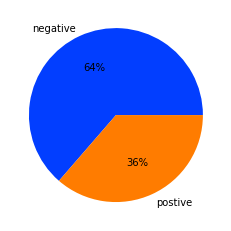

<Axes: xlabel='comment count', ylabel='sentiment'>

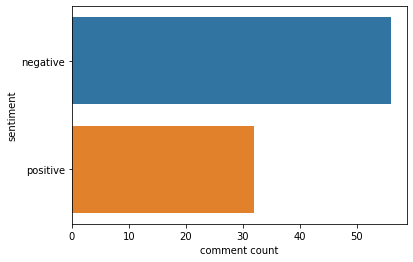

In [32]:
#Pie chart for dashboard
palette_color = sns.color_palette('bright')
labels = ['negative', 'postive']
plt.pie(data=df_metric,x= 'comment', labels=labels, colors=palette_color, autopct='%.0f%%')
plt.show()

#Barchart for dashboard
bars = sns.barplot(x='comment',y='sentiment', data=df_metric)
bars.set(xlabel='comment count')
bars